In [1]:
import sys
import site
sys.path.insert(0, site.getusersitepackages())

In [2]:
import numpy as np
import uproot
import awkward as ak
import collections
import matplotlib
import matplotlib.pyplot as plt
import glob
# import ipywidgets as widgets
# %matplotlib widget

# Wider Cells
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [3]:
plt.tight_layout()
matplotlib.rcParams['figure.figsize'] = (12, 8)
font = {'size'   : 16}
matplotlib.rc('font', **font)
plt.rcParams["legend.markerscale"] = 3

<Figure size 432x288 with 0 Axes>

In [4]:
runs = [505,508,509,510,521,522]

In [5]:
run = 508
files = glob.glob(f"/eos/experiment/wcte/data/readout_commissioning/offline/dataR{run}S*P*.root")
len(files)

6

In [6]:
i=0
f = files[i]
print(f)
tree = uproot.open(f+":WCTEReadoutWindows")

/eos/experiment/wcte/data/readout_commissioning/offline/dataR508S0P0.root


In [7]:
tree          = uproot.open(files[0]+":WCTEReadoutWindows")
event_numbers = [tree['event_number'].array().to_numpy()]
window_times  = [tree['window_time'].array().to_numpy()]

In [9]:
for f in files[1:]:
    tree2 = uproot.open(f+":WCTEReadoutWindows")
    event_numbers.append(tree2['event_number'].array().to_numpy()+event_numbers[-1].max()+1)
    window_times.append(tree2['window_time'].array().to_numpy())

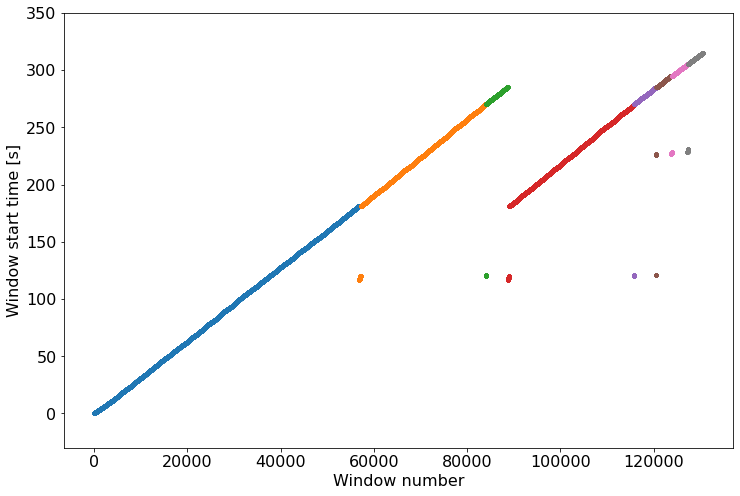

In [10]:
for i, (e, t) in enumerate(zip(event_numbers, window_times)):
    plt.plot(e, t/1e9, '.', label=f"part file {i}")
    #plt.xlim((0,200000))
    plt.ylim((-30,350))
plt.xlabel("Window number")
plt.ylabel("Window start time [s]");
# plt.legend();

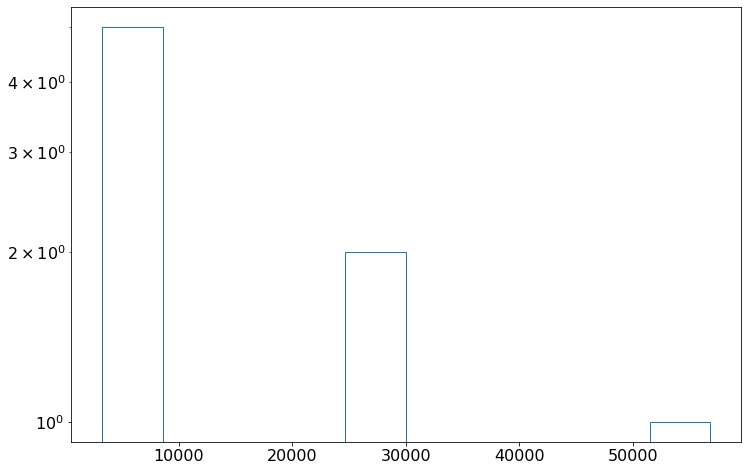

In [11]:
length = []
for i in event_numbers:
    length.append(len(i))
    
plt.hist(length, histtype='step');
plt.yscale('log')

In [13]:
# Read the file tree
tree = uproot.open(files[0]+":WCTEReadoutWindows")

# Max number of events (windows)
max_event_number = ak.max(tree['event_number'].array())
# Max number of mPMTs
max_card_number  = 131

# Initialize the 2-dimensional array that we're going to convert into a 2D Histogram
hist = np.zeros((max_event_number+1, max_card_number+1))


# Iterate through chunks of 1 MB. We're iterating through the event number and the mPMT_id that was hit in that event
for array in tree.iterate(['event_number', 'hit_mpmt_card_ids'], step_size='1 MB'):
    # Broadcast the number of events to match the number of hits in every window
    event_id_batch, card_id_batch = ak.broadcast_arrays(array['event_number'], array['hit_mpmt_card_ids'])
    
    # Print summary info
    print(f"Batch of windows {ak.min(array['event_number'])} to {ak.max(array['event_number'])} has {ak.sum(ak.num(card_id_batch))} hits (average {ak.mean(ak.num(card_id_batch))} hits per window)\n")
    
    # Update hist with event and card_id info and batch counter
    hist    += np.histogram2d(ak.flatten(event_id_batch).to_numpy(), ak.flatten(card_id_batch).to_numpy(), bins=(np.arange(max_event_number+2)-0.5, np.arange(max_card_number+2)-0.5))[0]

Batch of windows 0 to 16809 has 46032320 hits (average 2738.389054134444 hits per window)

Batch of windows 16810 to 33619 has 15057231 hits (average 895.7305770374777 hits per window)

Batch of windows 33620 to 50429 has 15950993 hits (average 948.8990481856038 hits per window)

Batch of windows 50430 to 56819 has 5561792 hits (average 870.3899843505477 hits per window)



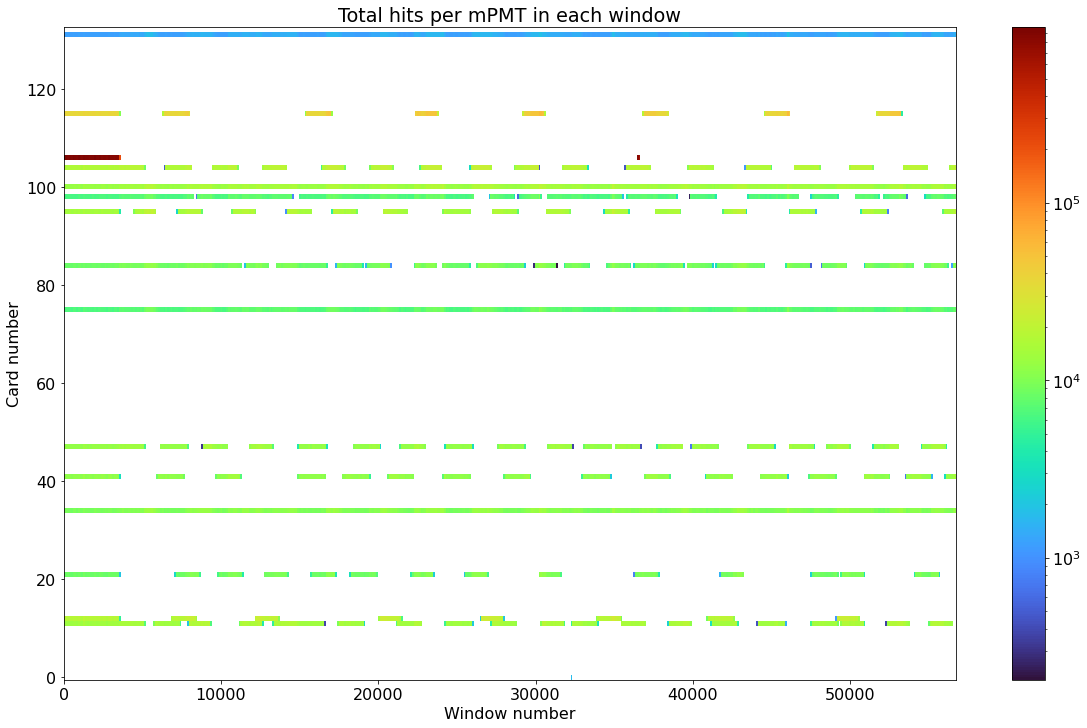

In [105]:
event_ids = np.repeat(np.arange(max_event_number+1), max_card_number+1)
card_ids  = np.tile(np.arange(max_card_number+1), max_event_number+1)

counts = hist.flatten()

fig, ax = plt.subplots(figsize=(20,12))

h = ax.hist2d(event_ids[event_ids<max_event_number-65], card_ids[event_ids<max_event_number-65], weights=counts[event_ids<max_event_number-65], bins=(500, np.arange(134)-0.5), norm='log', cmap='turbo')

ax.set_xlabel("Window number")
ax.set_ylabel("Card number")
ax.set_title("Total hits per mPMT in each window")

fig.colorbar(h[3], ax=ax)

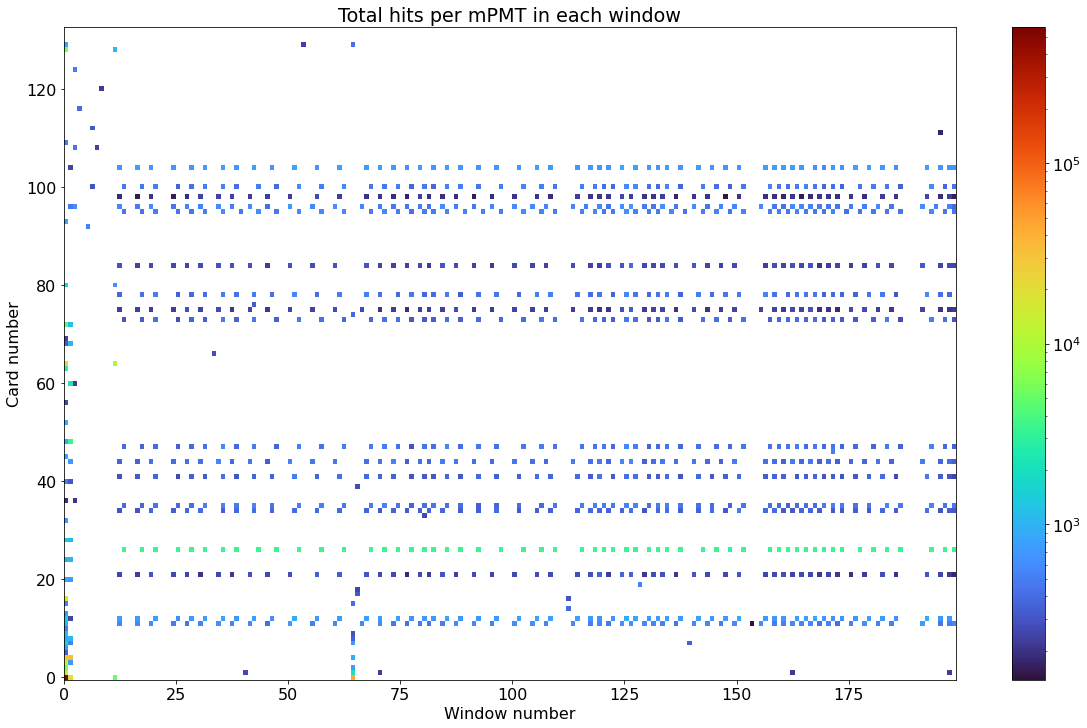

In [40]:
event_range = np.arange(000,200)
event_ids = np.repeat(np.arange(max_event_number+1)[event_range], max_card_number+1)
card_ids = np.tile(np.arange(max_card_number+1), len(event_range))
counts = hist[event_range].flatten()
fig, ax = plt.subplots(figsize=(20,12))
h = ax.hist2d(event_ids, card_ids, weights=counts, bins=(event_range, np.arange(134)-0.5), norm='log', cmap='turbo')
ax.set_xlabel("Window number")
ax.set_ylabel("Card number")
ax.set_title("Total hits per mPMT in each window")
fig.colorbar(h[3], ax=ax)

In [15]:
data = {k: v.array() for k, v in tree.items()}
for k, v in data.items():
    print(f"{k:<30} {v.type}")

window_time                    56820 * float64
window_cc                      56820 * uint64
run_id                         56820 * int32
sub_run_id                     56820 * int32
spill_counter                  56820 * int32
event_number                   56820 * int32
trigger_types                  56820 * var * int32
trigger_times                  56820 * var * float32
led_gains                      56820 * var * float32
led_dacsettings                56820 * var * float32
led_ids                        56820 * var * int32
hit_mpmt_card_ids              56820 * var * int32
hit_pmt_channel_ids            56820 * var * int32
hit_mpmt_slot_ids              56820 * var * int32
hit_pmt_position_ids           56820 * var * int32
hit_pmt_charges                56820 * var * float32
hit_pmt_times                  56820 * var * float64
hit_ccs                        56820 * var * uint64
hit_message_numbers            56820 * var * uint32
meassage_card_ids              56820 * var * int32
m

In [16]:
triggers = (data['hit_mpmt_card_ids']==131)&(data['hit_pmt_channel_ids']==5)
windows_with_trigger = ak.any(triggers, axis=1)

In [17]:
trigger_times = data['hit_pmt_times'][triggers][windows_with_trigger]

In [18]:
trigger_times

<Array [[5.77e+05, 8.39e+05, ..., 1.03e+07], ...] type='18106 * var * float64'>

Text(0.5, 0, 'Time between trigger hits [ns]')

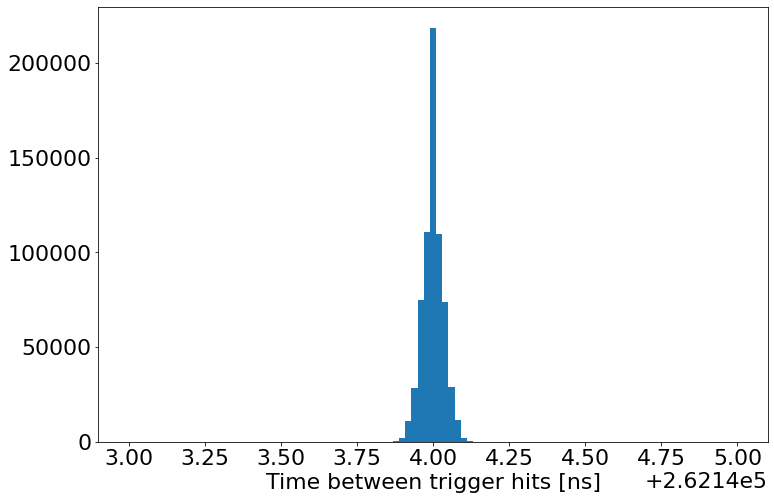

In [19]:
plt.hist(np.diff(ak.flatten(trigger_times)), bins=np.linspace(262143, 262145, 100))
plt.xlabel('Time between trigger hits [ns]')

Text(0.5, 0, 'Time between trigger hits [ns]')

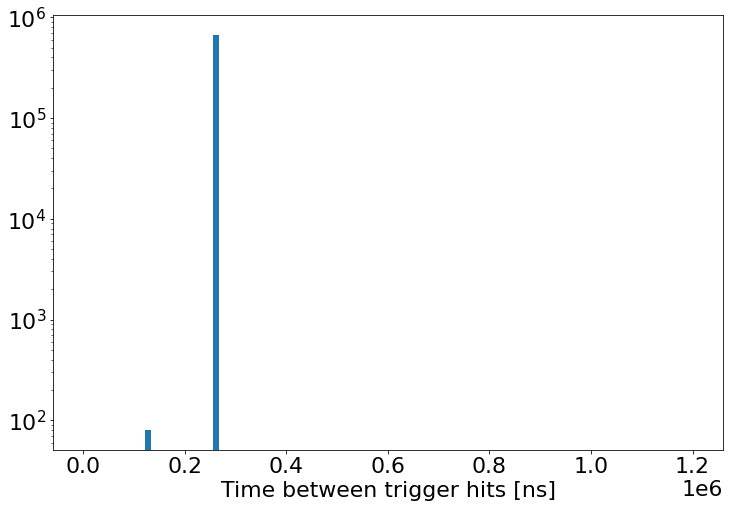

In [20]:
plt.hist(np.diff(ak.flatten(trigger_times)), bins=np.linspace(1000, 1200000, 100))
plt.yscale('log')
plt.xlabel('Time between trigger hits [ns]')

In [21]:
first_trigger_in_window = ak.firsts(trigger_times)

In [22]:
first_trigger_in_window

<Array [5.77e+05, 5.77e+05, ..., 3.14e+05, 3.42e+10] type='18106 * ?float64'>

In [23]:
bad_ids = data['meassage_card_ids']>132
bad_id_count = np.count_nonzero(ak.flatten(bad_ids))
message_count = len(ak.flatten(bad_ids))
print(f"{bad_id_count} out of {message_count} messages ({100*bad_id_count/message_count}%) have invalid card IDs")

101 out of 167350 messages (0.06035255452644159%) have invalid card IDs


In [24]:
ak.flatten(data['message_ccs'][bad_ids])

<Array [49207, 49207, 49207, ..., 4289723647, 4290771967] type='101 * uint64'>

(array([64.,  0.,  2.,  1.,  1.,  2.,  0.,  4.,  4., 23.]),
 array([4.92070000e+04, 4.29121483e+08, 8.58193759e+08, 1.28726604e+09,
        1.71633831e+09, 2.14541059e+09, 2.57448286e+09, 3.00355514e+09,
        3.43262742e+09, 3.86169969e+09, 4.29077197e+09]),
 <BarContainer object of 10 artists>)

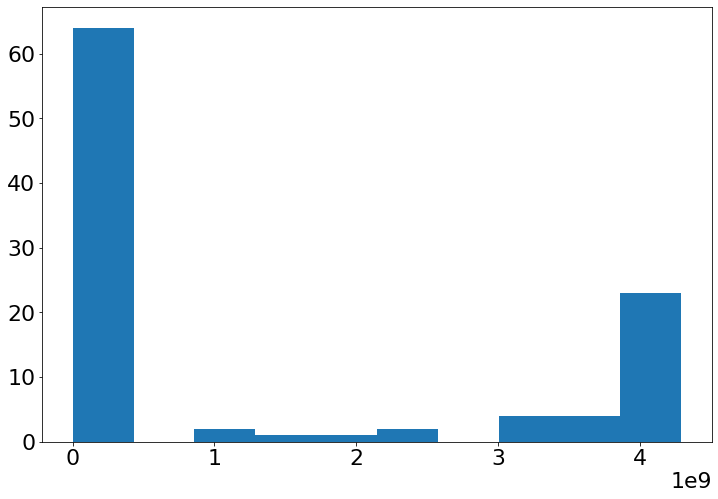

In [25]:
plt.hist(ak.flatten(data['message_ccs'][bad_ids]))

(array([  101., 37015.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3388.]),
 array([1.36550000e+05, 1.51726938e+07, 3.02088376e+07, 4.52449814e+07,
        6.02811252e+07, 7.53172690e+07, 9.03534128e+07, 1.05389557e+08,
        1.20425700e+08, 1.35461844e+08, 1.50497988e+08]),
 <BarContainer object of 10 artists>)

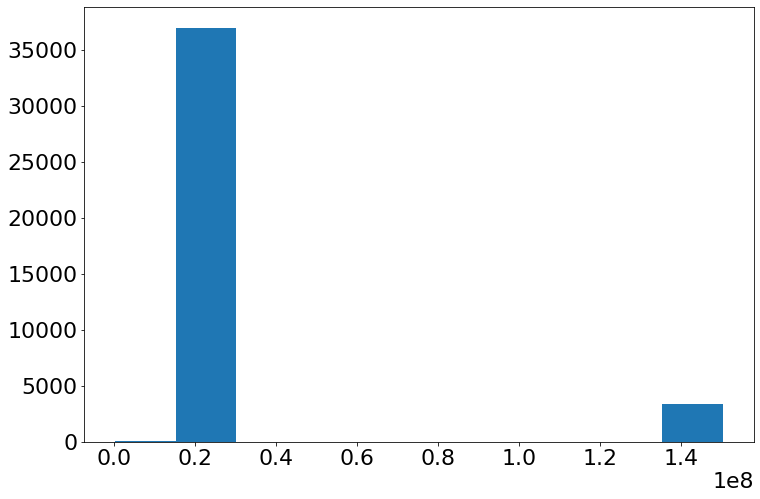

In [26]:
plt.hist(ak.flatten(data['hit_ccs'][data["hit_mpmt_card_ids"]>132]))

(array([273044., 240696., 170224.,  83202., 314705., 156173., 185558.,
        168489., 151946., 221255.]),
 array([1.73590000e+04, 4.29512333e+08, 8.59007307e+08, 1.28850228e+09,
        1.71799726e+09, 2.14749223e+09, 2.57698720e+09, 3.00648218e+09,
        3.43597715e+09, 3.86547212e+09, 4.29496710e+09]),
 <BarContainer object of 10 artists>)

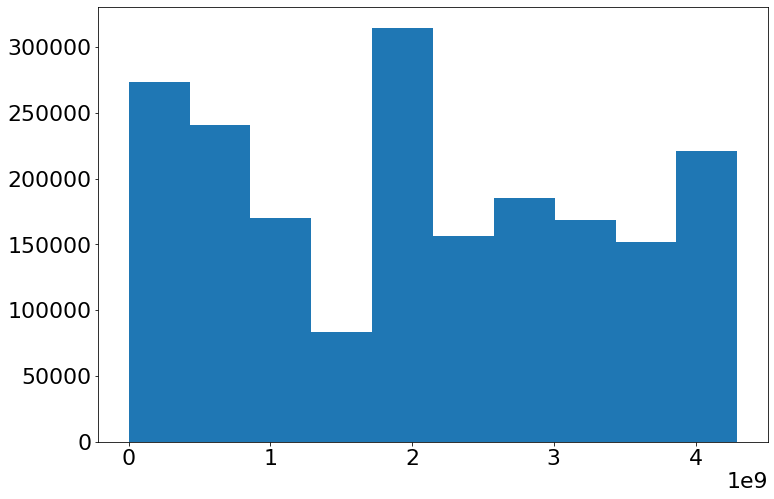

In [27]:
plt.hist(ak.flatten(data['hit_ccs'][data["hit_mpmt_card_ids"]==21]))

Text(0.5, 0, 'Charge of hits from mPMT 21')

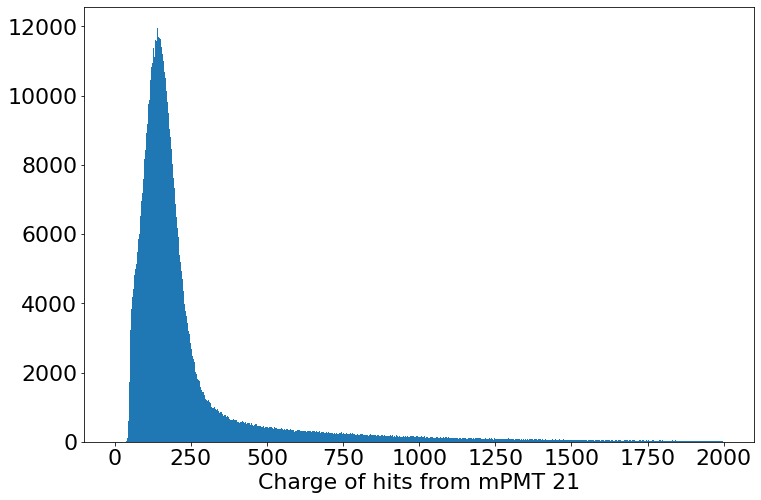

In [28]:
plt.hist(ak.flatten(data['hit_pmt_charges'][data['hit_mpmt_card_ids']==21]), bins=np.arange(0,2000))
plt.xlabel("Charge of hits from mPMT 21")

Text(0.5, 0, 'Charge of hits in messages with invalid card IDs')

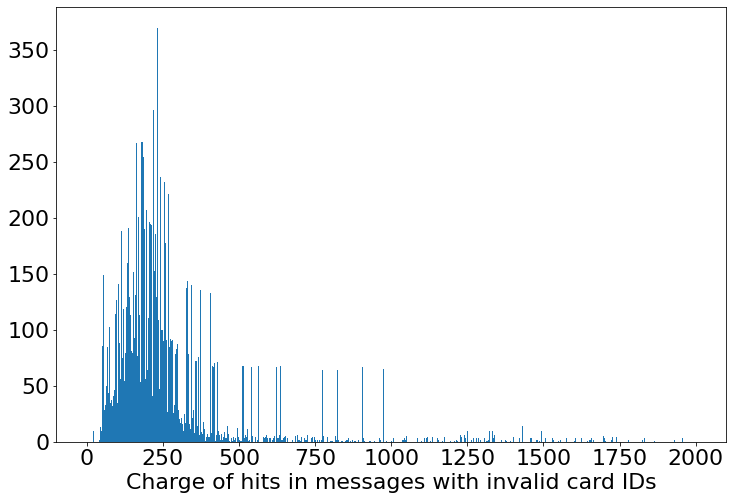

In [29]:
plt.hist(ak.flatten(data['hit_pmt_charges'][data['hit_mpmt_card_ids']>132]), bins=np.arange(0,2000))
plt.xlabel("Charge of hits in messages with invalid card IDs")

Text(0, 0.5, 'Total hits from card')

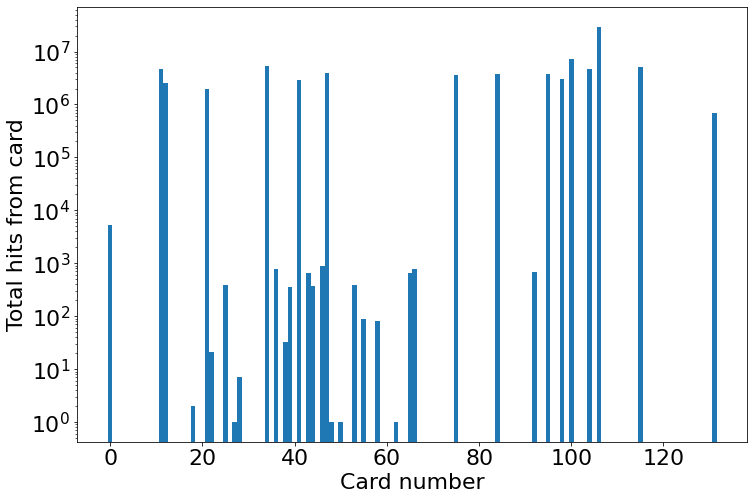

In [30]:
plt.hist(ak.flatten(data['hit_mpmt_card_ids']), bins=np.arange(133)-0.5)
plt.yscale('log')
plt.xlabel("Card number")
plt.ylabel("Total hits from card")

Text(0.5, 0, 'Hit time in window [ms]')

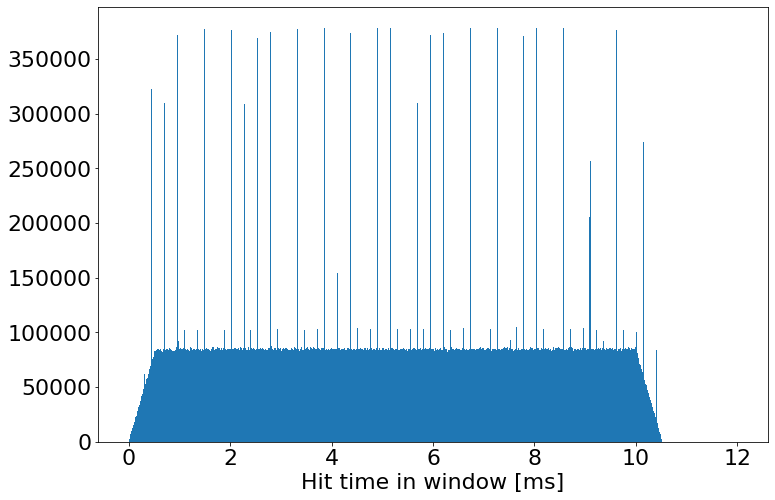

In [31]:
plt.hist(ak.flatten(data['hit_pmt_times'])/1e6, bins=1000, range=(0,12))
plt.xlabel("Hit time in window [ms]")

In [32]:
times = ak.flatten(data["hit_pmt_times"][:max_event_number-65]+data["window_time"][:max_event_number-65]).to_numpy()
card_ids = ak.flatten(data["hit_mpmt_card_ids"][:max_event_number-65]).to_numpy()

In [33]:
times.shape

(82565895,)

In [34]:
card_ids.shape

(82565895,)

In [35]:
plt.hist2d(, )

SyntaxError: invalid syntax (2871818580.py, line 1)